## Generate an emulator for the correlation function of flicker noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

In [2]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
dtime = 2.
ntime = 2860
t_list = np.arange(ntime) * dtime
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)


In [3]:
from flicker_model import flicker_cov_vec
import numpy as np

class FlickerCorrEmulator:
    def __init__(self, logfc, tau_list, wnoise_var):
        self.ref_logf0 = -4.  # Reference logf0 for the emulator
        self.wnoise_var = wnoise_var
        self.logfc = logfc
        self.tau_list = tau_list
        
        # Generate training data
        alpha_list = np.linspace(1.1, 4, 3000)
        from tqdm import tqdm
        corr_list = np.array([flicker_cov_vec(tau_list, 10.**self.ref_logf0, 10.**logfc, alpha, white_n_variance=0.)
                            for alpha in tqdm(alpha_list)])
        
        # Train the emulator
        from MomentEmu import PolyEmu
        self.emulator = PolyEmu(alpha_list.reshape(-1,1), corr_list, forward=True, backward=False, 
                               max_degree_forward=20, test_size=0.3, RMSE_tol=1e-5)
    
    def __call__(self, logf0, alpha, indices=None):
        """
        Emulate the flicker correlation function for given logf0 and alpha.
        """
        correction_factor = 10.**((logf0 - self.ref_logf0) * alpha)
        result = self.emulator.forward_emulator(np.array([[alpha]]))[0] * correction_factor
        result[0] += self.wnoise_var  # Add white noise variance to the first element
        if indices is None:
            return result
        return result[indices]

# Create the emulator
flicker_emulator = FlickerCorrEmulator(logfc=logfc, tau_list=t_list, wnoise_var=2.5e-6)

100%|██████████| 3000/3000 [10:02<00:00,  4.98it/s]


Generating forward emulator...
Forward emulator maximum fractional error: 11.857634146221045


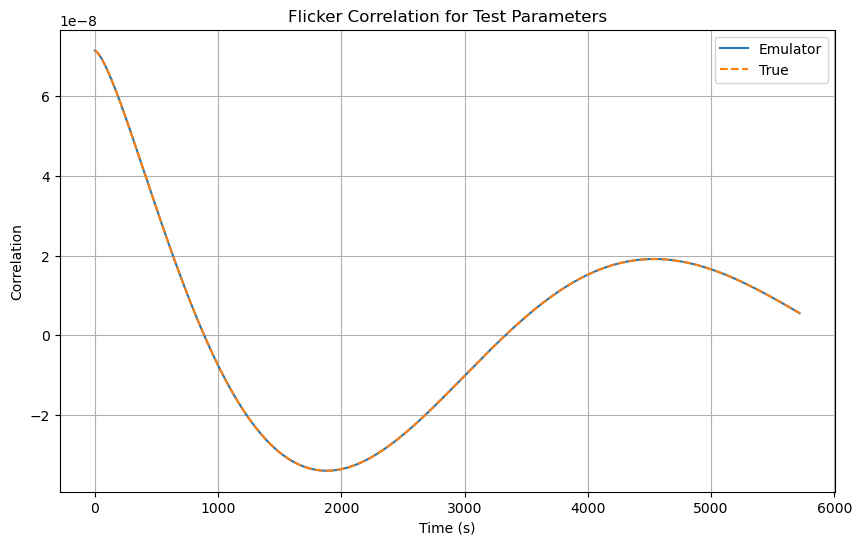

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))


alpha_test = 2.5678
logf0_test = -4.32  # Example logf0 value, can be adjusted
test_corr = flicker_emulator(logf0=logf0_test, alpha=alpha_test)
true_corr = flicker_cov_vec(t_list, 10.**logf0_test, 10.**logfc, alpha_test,  white_n_variance=2.5e-6)

plt.plot(t_list[1:], test_corr[1:], label=f'Emulator')
plt.plot(t_list[1:], true_corr[1:], label=f'True', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.title('Flicker Correlation for Test Parameters')
plt.legend()
plt.grid()
plt.show()


In [5]:
%timeit test_corr = flicker_emulator(logf0=logf0_test, alpha=alpha_test)

105 μs ± 1.08 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%timeit true_corr = flicker_cov_vec(t_list, 10.**logf0_test, 10.**logfc, alpha_test,  white_n_variance=2.5e-6)

181 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


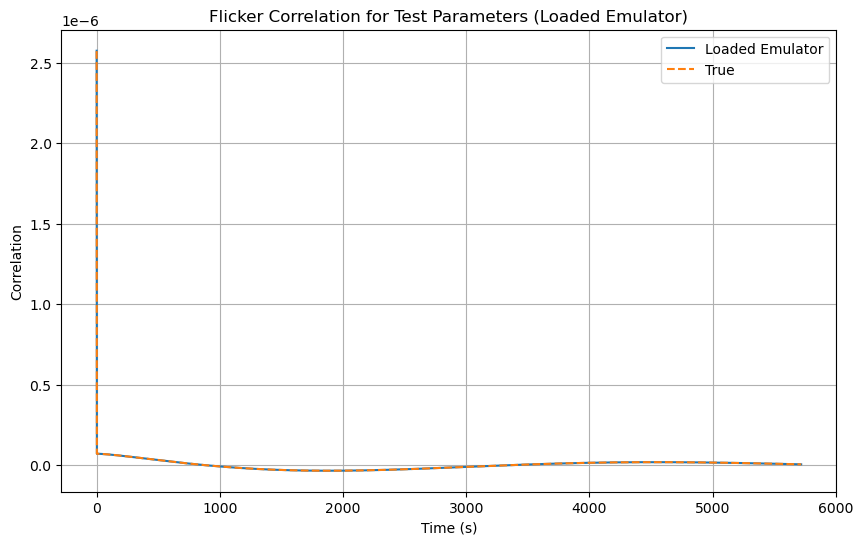

In [7]:
# Save the emulator for later use
import pickle
with open('flicker_corr_emulator.pkl', 'wb') as f:
    pickle.dump(flicker_emulator, f)

# Load the emulator
with open('flicker_corr_emulator.pkl', 'rb') as f:
    flicker_corr_emulator_loaded = pickle.load(f)
# Test the loaded emulator
test_corr_loaded = flicker_corr_emulator_loaded(logf0=logf0_test, alpha=alpha_test)
plt.figure(figsize=(10, 6))
plt.plot(t_list, test_corr_loaded, label='Loaded Emulator')
plt.plot(t_list, true_corr, label='True', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.title('Flicker Correlation for Test Parameters (Loaded Emulator)')
plt.legend()
plt.grid()
plt.show()  